## mapping for ireland data

In [3]:
import sys,os,shutil,subprocess
import glob
from importlib import reload
import numpy as np
import pandas as pd
pd.set_option('display.width', 200)
import pylab as plt
import matplotlib as mpl
import seaborn as sns
import geopandas as gpd
import random
from snipgenie import trees, app, plotting
from shapely.geometry import Point, LineString, Polygon, MultiPolygon

In [6]:
counties = gpd.read_file('/storage/btbgenie/monaghan/metadata/counties.shp')

In [ ]:
meta = pd.read_csv('/storage/btbgenie/mbovis_ireland/all_ireland_samples.csv',index_col=0)
#meta = meta.drop(columns=['filename','pair'])
#meta = meta.rename(columns={'SB':'spoligotype'})
meta['Species'] = meta.Species.fillna('Cow')
meta['name'] = meta.index
meta

In [ ]:
cvrl = pd.read_csv('/storage/btbgenie/monaghan/metadata/cvrl_isolates_nov22.csv')
x=meta.merge(cvrl, on='aliquot',how='inner').dropna()
#x = gpd.GeoDataFrame(x,geometry=gpd.points_from_xy(cvrl.lon, cvrl.lat)).set_crs('WGS 84')

## make fake spatial data 

In [9]:
def make_points(x):
    """Make points"""

    if x.county == 'Wicklow':
        bounds=(-6.7,52.8,-6.1,53.2)
    elif x.county == 'Monaghan':
        bounds = (-6.0,54.0,-7.1,54.5)
    else:
        bounds = (-6.4,53.8,-6.1,54.2)
    points = []
    minx, miny, maxx, maxy = bounds   
    point = (random.uniform(minx, maxx), random.uniform(miny, maxy))
    return point

In [ ]:
#make random points inside geometry

from shapely.geometry import Point
def random_point_in_shp(x):
   
    if x.county not in counties.NAME_TAG.unique():
        x.county=random.choice(['Armagh'])
    shp = counties[counties.NAME_TAG==x.county].iloc[0] 
    #print (shp)
    within = False
    bounds = shp.geometry.bounds    
    while within is False:
        x = np.random.uniform(bounds[0], bounds[2])
        y = np.random.uniform(bounds[1], bounds[3])        
        within = shp.geometry.contains(Point(x, y))
        #print (within)
    return x,y

#meta.apply(random_point_in_shp,1)

In [ ]:
meta['coord'] = meta.apply(random_point_in_shp,1)
meta[['LONG','LAT']] = pd.DataFrame(meta.coord.tolist(), index=meta.index)

In [35]:
sdist = pd.read_csv('/storage/btbgenie/all_ireland_results/snpdist.csv',index_col=0)
#print (sdist)

def find_neighbours(x, n=4):
    """find neighbours from snp distance matrix"""
  
    vals = list(x.sort_values()[1:n].index)
    return ';'.join(vals)

nearest = sdist.apply(find_neighbours,1)
#nearest
meta['nearest'] = nearest

## encode snp data into field

In [36]:
snpm = pd.read_csv('/storage/btbgenie/all_ireland_results/core.txt',sep=' ').set_index('pos').T
snpm = snpm.fillna('N')
meta['snps'] = snpm.apply(snp_typing.encode_snps,1)

In [37]:
print (meta[:4])
meta.to_csv('ireland_test_data.csv')

          county species source  batch aliquot       name                                    coord      LONG        LAT                        nearest  \
sample                                                                                                                                                   
ERR125617     NI     Cow  Other    NaN     NaN  ERR125617  (-6.637041584408253, 54.27704394903983) -6.637042  54.277044  ERR125621;ERR125622;ERR125623   
ERR125622     NI     Cow  Other    NaN     NaN  ERR125622  (-6.466771307291072, 54.41935577556797) -6.466771  54.419356  ERR125621;ERR125622;ERR125623   
ERR125598     NI     Cow  Other    NaN     NaN  ERR125598   (-6.66465936013807, 54.35150425997646) -6.664659  54.351504  ERR125601;ERR125625;ERR125605   
ERR125612     NI     Cow  Other    NaN     NaN  ERR125612   (-6.58425381759807, 54.46611179318391) -6.584254  54.466112  ERR125621;ERR125622;ERR125623   

                                                        snps  
sample      

In [ ]:
gdf = gpd.GeoDataFrame(meta, geometry=gpd.points_from_xy(meta.LONG, meta.LAT),crs='EPSG:4326')
fig,ax=plt.subplots(1,1,figsize=(10,10))
counties.plot(ax=ax,color='lightgray',ec='black')
gdf.plot(ax=ax,column='county')
ax.set_xlim(-10,-6)
ax.set_ylim(52.5,55)
plt.tight_layout()
fig.savefig('ireland_samples_map_test.jpg',dpi=150)
len(gdf[gdf.county=='Monaghan'])

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(10,10))
hb = ax.hexbin(
    gdf.geometry.x, 
    gdf.geometry.y, 
    gridsize=40,
    linewidths=0,
    alpha=0.9, 
    cmap='GnBu',    
)
counties.plot(ax=ax,color='none',ec='black')
ax.axis('off')

## clade composition per county

In [156]:
final = pd.read_csv('/storage/btbgenie/all_ireland_results/metadata.csv')

In [173]:
df=final.groupby(['county','snp100']).agg({'sample':np.size}).reset_index()

In [174]:
#df['snp100']=pd.Categorical(df['snp100'] , [11,12,18,3,5,6,7,8])
df['snp100']=df.snp100.astype(str)
df=df.sort_values('snp100')

In [191]:
df=df[df['sample']>3]
df['color'],colormap=plotting.get_color_mapping(df,'snp100',cmap='Set1')
#p=pd.pivot_table(df,index='county',columns='snp100',values='sample')
counties['cent'] = counties.geometry.centroid
counties['X'] = counties.cent.x
counties['Y'] = counties.cent.y
gdf = counties.merge(df,left_on='NAME_TAG',right_on='county',how='right')
#gdf.iloc[0]

/tmp/ipykernel_2373733/1669003882.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  counties['cent'] = counties.geometry.centroid


(-10.924406855, -5.165025645, 51.18654548, 55.63761892)

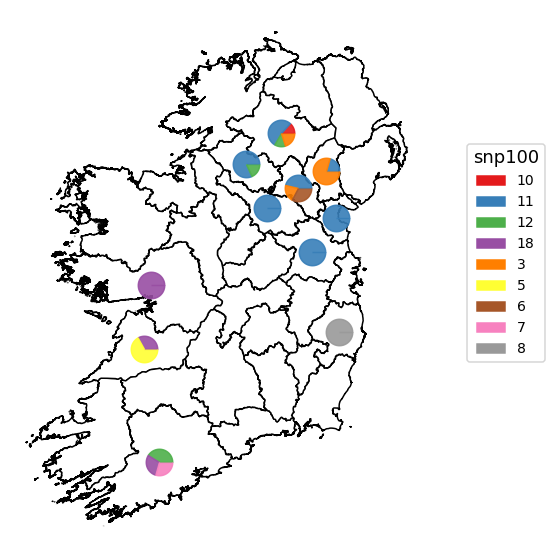

In [194]:
reload(plotting)

fig,ax=plt.subplots(1,1,figsize=(12,10))
counties.plot(ec='black',color='white',ax=ax)

for _, g in gdf.groupby('county'):
    #print (g[['county','X','Y','sample','color']])
    r=g.iloc[0]    
    vals = list(g['sample'])
    colors = list(g.color)    
    ax = plotting.draw_pie(vals, r.X, r.Y, colors, 700, ax)
p = plotting.make_legend(fig,colormap,(.9, .7),'snp100')   
ax.axis('off')   